In [1]:
import os
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Paths to Synthea CSVs (ensure these match your actual structure)
DATA_DIR = "../data/raw/"
PROCESSED_DATA_DIR = "../data//processed/"

In [3]:
patients = pd.read_csv(os.path.join(DATA_DIR, "patients.csv"))
conditions = pd.read_csv(os.path.join(DATA_DIR, "conditions.csv"))
medications = pd.read_csv(os.path.join(DATA_DIR, "medications.csv"))
encounters = pd.read_csv(os.path.join(DATA_DIR, "encounters.csv"))

In [4]:
for file in [
    "patients.csv",
    "conditions.csv",
    "medications.csv",
    "encounters.csv",
    "observations.csv",
]:
    print(f"\n{file} columns:")
    print(pd.read_csv(f"../data/raw/{file}").columns.tolist())


patients.csv columns:
['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE']

conditions.csv columns:
['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION']

medications.csv columns:
['START', 'STOP', 'PATIENT', 'PAYER', 'ENCOUNTER', 'CODE', 'DESCRIPTION', 'BASE_COST', 'PAYER_COVERAGE', 'DISPENSES', 'TOTALCOST', 'REASONCODE', 'REASONDESCRIPTION']

encounters.csv columns:
['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER', 'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST', 'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE', 'REASONDESCRIPTION']

observations.csv columns:
['DATE', 'PATIENT', 'ENCOUNTER', 'CATEGORY', 'CODE', 'DESCRIPTION', 'VALUE', 'UNITS', 'TYPE']


In [5]:
# Convert relevant columns to datetime
encounters["START"] = pd.to_datetime(encounters["START"], errors="coerce")
patients["DEATHDATE"] = pd.to_datetime(patients["DEATHDATE"], errors="coerce")
patients["BIRTHDATE"] = pd.to_datetime(patients["BIRTHDATE"], errors="coerce")
medications["BASE_COST"] = pd.to_numeric(medications["BASE_COST"], errors="coerce")
medications["TOTALCOST"] = pd.to_numeric(medications["TOTALCOST"], errors="coerce")
encounters["BASE_ENCOUNTER_COST"] = pd.to_numeric(
    encounters["BASE_ENCOUNTER_COST"], errors="coerce"
)

# FEATURE ENGINEERING

In [6]:
# Age, gender, race, marital, ethnicity
patients["age"] = 2025 - patients["BIRTHDATE"].dt.year
patients["death_flag"] = patients["DEATHDATE"].notna().astype(int)
patients = patients.rename(
    columns={
        "Id": "patient",
        "GENDER": "gender",
        "MARITAL": "marital_status",
        "RACE": "race",
        "ETHNICITY": "ethnicity",
    }
)
patient_df = patients[
    ["patient", "gender", "age", "marital_status", "race", "ethnicity", "death_flag"]
]

In [7]:
patient_df.head()

,patient,gender,age,marital_status,race,ethnicity,death_flag
0,f4db39b1-693d-e301-0a1f-41d26d3ced36,M,40,S,white,nonhispanic,0
1,e8503522-82ff-67a2-4dad-29281d6318de,M,60,M,white,nonhispanic,0
2,ac643af6-1a32-08ce-df40-1c31348bcb41,M,60,M,white,nonhispanic,0
3,358f26b9-a982-0346-55d3-65e8667f39e9,F,71,S,white,hispanic,0
4,1017741e-00f0-e3dc-5c93-f5b0053f2cc4,M,71,M,white,nonhispanic,0


In [8]:
# Number of encounters and average cost
encounter_features = (
    encounters.groupby("PATIENT")
    .agg(
        num_encounters=("Id", "count"),
        recent_encounter_type=(
            "ENCOUNTERCLASS",
            lambda x: x.iloc[-1] if len(x) > 0 else None,
        ),
        avg_encounter_cost=("BASE_ENCOUNTER_COST", "mean"),
    )
    .reset_index()
    .rename(columns={"PATIENT": "patient"})
)

In [9]:
encounter_features

,patient,num_encounters,recent_encounter_type,avg_encounter_cost
0,096aae79-612c-c566-d14b-ca23b5595cdb,141,wellness,117.848511
1,1017741e-00f0-e3dc-5c93-f5b0053f2cc4,56,wellness,111.548929
2,10182af0-da35-e957-8a8f-36ad80ae3191,51,ambulatory,132.966863
3,144396bf-ca8b-5aa6-2511-4a9bb8fe1ef5,107,wellness,125.001028
4,15a351f5-ada6-1fc3-dfd2-7af42d1731b2,59,wellness,130.083390
...,...,...,...,...
135,f2db174c-fb9d-3408-8bf4-8bff7826d2f1,136,wellness,129.510074
136,f4db39b1-693d-e301-0a1f-41d26d3ced36,55,outpatient,100.247455
137,f7019a56-1940-b131-f5e2-39439c16a942,112,ambulatory,125.528929
138,f7f39409-b7b4-224d-6354-2acd6f94f2f8,54,wellness,108.140741


In [10]:
encounters.head()

,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
0,fa301d15-4761-7c57-6633-5c81cc43d233,1997-11-02 15:42:51+00:00,1997-11-02T15:57:51Z,f4db39b1-693d-e301-0a1f-41d26d3ced36,1977f8c2-6ece-3f46-8c60-b5961bb867a9,4d12f6b0-c28e-348d-975f-25a388ef89ee,4d71f845-a6a9-3c39-b242-14d25ef86a8d,wellness,410620009,Well child visit (procedure),136.80,1329.88,0.0,NaN,NaN
1,9d4fb2ca-abbd-4270-822a-880cfc94bfb0,1999-11-16 15:42:51+00:00,1999-11-17T15:42:51Z,f4db39b1-693d-e301-0a1f-41d26d3ced36,a0b6ec0c-e587-3b2a-bf9f-248849f29ee5,72e3edc9-9294-33d5-b927-49c56433871d,d47b3510-2895-3b70-9897-342d681c769d,inpatient,183452005,Encounter Inpatient,87.71,615.64,0.0,1.241710e+14,Chronic intractable migraine without aura
2,acde7c73-fba1-be42-58ad-314c7c6465a2,2000-02-24 15:42:51+00:00,2000-02-25T15:42:51Z,f4db39b1-693d-e301-0a1f-41d26d3ced36,a0b6ec0c-e587-3b2a-bf9f-248849f29ee5,72e3edc9-9294-33d5-b927-49c56433871d,d47b3510-2895-3b70-9897-342d681c769d,inpatient,183452005,Encounter Inpatient,87.71,711.67,0.0,8.242300e+07,Chronic pain
3,aaf60ab9-3f5e-2ff1-8300-a2dbdacb04ce,2000-05-01 15:42:51+00:00,2000-05-02T15:42:51Z,f4db39b1-693d-e301-0a1f-41d26d3ced36,a0b6ec0c-e587-3b2a-bf9f-248849f29ee5,72e3edc9-9294-33d5-b927-49c56433871d,d47b3510-2895-3b70-9897-342d681c769d,inpatient,183452005,Encounter Inpatient,87.71,9237.66,0.0,1.964160e+08,Impacted molars
4,96e42627-d0ab-7e1a-30dc-0731aa49151f,2000-11-19 15:42:51+00:00,2000-11-19T15:57:51Z,f4db39b1-693d-e301-0a1f-41d26d3ced36,1977f8c2-6ece-3f46-8c60-b5961bb867a9,4d12f6b0-c28e-348d-975f-25a388ef89ee,4d71f845-a6a9-3c39-b242-14d25ef86a8d,wellness,410620009,Well child visit (procedure),136.80,704.20,0.0,NaN,NaN


In [13]:
# Simulate readmission using multiple encounter variables
readmit_flags = []

for patient in patients["patient"]:
    patient_encounters = encounters[encounters["PATIENT"] == patient].copy()
    patient_encounters["START"] = pd.to_datetime(
        patient_encounters["START"], errors="coerce"
    )
    patient_encounters.sort_values("START", inplace=True)

    readmitted = 0

    for i in range(1, len(patient_encounters)):
        prev = patient_encounters.iloc[i - 1]
        curr = patient_encounters.iloc[i]

        # 1. Was the second visit within 30 days?
        within_30_days = (curr["START"] - prev["START"]) <= timedelta(days=30)

        # 2. Was the second visit a readmission-worthy type?
        readmit_type = curr["ENCOUNTERCLASS"] in ["inpatient", "emergency"]

        # 3. Was it for a similar reason?
        same_reason = prev["REASONCODE"] == curr["REASONCODE"]

        # 4. Optionally: Same provider/org (optional signal)
        # same_provider = prev["PROVIDER"] == curr["PROVIDER"]

        if within_30_days and readmit_type and same_reason:
            readmitted = 1
            break

    readmit_flags.append({"patient": patient, "readmitted": readmitted})

readmit_df = pd.DataFrame(readmit_flags)

In [14]:
readmit_df.head()

,patient,readmitted
0,f4db39b1-693d-e301-0a1f-41d26d3ced36,0
1,e8503522-82ff-67a2-4dad-29281d6318de,0
2,ac643af6-1a32-08ce-df40-1c31348bcb41,1
3,358f26b9-a982-0346-55d3-65e8667f39e9,0
4,1017741e-00f0-e3dc-5c93-f5b0053f2cc4,0


<Axes: xlabel='readmitted', ylabel='count'>

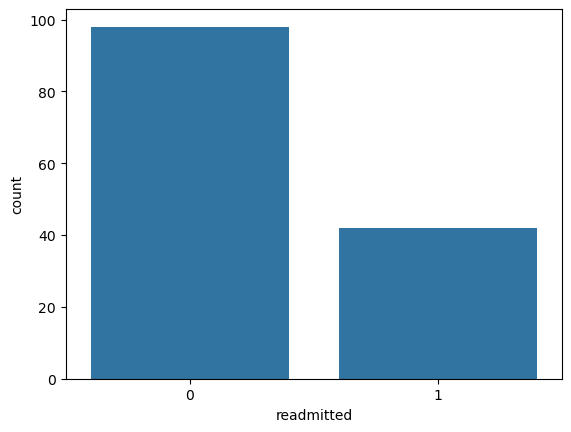

In [15]:
sns.countplot(x="readmitted", data=readmit_df)

In [16]:
# Conditions: count and chronic flag (e.g., diabetes, COPD, asthma)
chronic_keywords = ["diabetes", "copd", "asthma", "hypertension", "chronic"]
conditions["is_chronic"] = (
    conditions["DESCRIPTION"]
    .str.lower()
    .apply(lambda x: any(keyword in x for keyword in chronic_keywords))
)
cond_features = (
    conditions.groupby("PATIENT")
    .agg(
        num_conditions=("DESCRIPTION", "count"),
        chronic_disease_flag=("is_chronic", "max"),
    )
    .reset_index()
    .rename(columns={"PATIENT": "patient"})
)

In [17]:
# Medications: count and costs
med_features = (
    medications.groupby("PATIENT")
    .agg(
        num_medications=("DESCRIPTION", "count"),
        avg_med_cost=("BASE_COST", "mean"),
        total_med_cost=("TOTALCOST", "sum"),
    )
    .reset_index()
    .rename(columns={"PATIENT": "patient"})
)

In [18]:
# ==== Final Merge ====
df = (
    patient_df.merge(encounter_features, on="patient", how="left")
    .merge(cond_features, on="patient", how="left")
    .merge(med_features, on="patient", how="left")
    .merge(readmit_df, on="patient", how="left")
)

In [19]:
df.head()

,patient,gender,age,marital_status,race,ethnicity,death_flag,num_encounters,recent_encounter_type,avg_encounter_cost,num_conditions,chronic_disease_flag,num_medications,avg_med_cost,total_med_cost,readmitted
0,f4db39b1-693d-e301-0a1f-41d26d3ced36,M,40,S,white,nonhispanic,0,55,outpatient,100.247455,21,True,11.0,498.663636,6279.27,0
1,e8503522-82ff-67a2-4dad-29281d6318de,M,60,M,white,nonhispanic,0,63,wellness,120.049048,61,True,146.0,0.717466,2243.87,0
2,ac643af6-1a32-08ce-df40-1c31348bcb41,M,60,M,white,nonhispanic,0,52,wellness,127.526923,53,True,43.0,0.425814,166.38,1
3,358f26b9-a982-0346-55d3-65e8667f39e9,F,71,S,white,hispanic,0,72,wellness,128.202083,37,True,13.0,250.130769,22400.91,0
4,1017741e-00f0-e3dc-5c93-f5b0053f2cc4,M,71,M,white,nonhispanic,0,56,wellness,111.548929,47,True,20.0,0.199000,6.05,0


In [20]:
df.isnull().sum()

patient                  0
gender                   0
age                      0
marital_status           5
race                     0
ethnicity                0
death_flag               0
num_encounters           0
recent_encounter_type    0
avg_encounter_cost       0
num_conditions           0
chronic_disease_flag     0
num_medications          2
avg_med_cost             2
total_med_cost           2
readmitted               0
dtype: int64

In [22]:
df.isnull().sum()

patient                  0
gender                   0
age                      0
marital_status           5
race                     0
ethnicity                0
death_flag               0
num_encounters           0
recent_encounter_type    0
avg_encounter_cost       0
num_conditions           0
chronic_disease_flag     0
num_medications          0
avg_med_cost             0
total_med_cost           0
readmitted               0
dtype: int64

In [21]:
# Fill NAs
df["num_encounters"] = df["num_encounters"].fillna(0).astype(int)
df["avg_encounter_cost"] = df["avg_encounter_cost"].fillna(0)
df["num_conditions"] = df["num_conditions"].fillna(0).astype(int)
df["chronic_disease_flag"] = df["chronic_disease_flag"].fillna(0).astype(int)
df["num_medications"] = df["num_medications"].fillna(0).astype(int)
df["avg_med_cost"] = df["avg_med_cost"].fillna(0)
df["total_med_cost"] = df["total_med_cost"].fillna(0)
df["readmitted"] = df["readmitted"].fillna(0).astype(int)

In [24]:
# Save to file
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
df.to_csv(f"{PROCESSED_DATA_DIR}/training_data.csv", index=False)
print(f"✅ Final training dataset saved to '{PROCESSED_DATA_DIR}training_data.csv'")

✅ Final training dataset saved to '../data//processed/training_data.csv'
